Neon, who works in a steam power plant, is asked to monitor the performance of a new system. The new system is running a Rankine cycle with water as the working fluid.

What is known:

The Schematic of the new system is shown on the left. The design data is:
* Condenser Pressure: 10 kPa
* Boiler Pressure: 16 MPa
* Steam temperature at the turbine inlet: 600ºC

The actual data measured by Neon are:

* P1 = 9 kPa       
* T1 = 38ºC
* P2 = 16 MPa    
* P3 = 15.9 MPa 
* P4 = 15.2 MPa  
* T4 = 625ºC
* P5 = 15 MPa     
* T5 = 600ºC
* P6 = 10 kPa

The pump has an efficiency of 85% and the turbine has an efficiency of 80%.   
The mass flow rate is 20 kg/s.

In [3]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt


In [39]:
def plot_water_curve(w):
    Ts = np.linspace(274, w.critical_temperature-0.1, 1000)
    Xs = 0
    T_line = []
    s_line = []
    for i in Ts:
        w.TX = i, 0.0
        T_line.append(w.T)
        s_line.append(w.s)

    Ts2 = np.linspace(w.critical_temperature-0.1, 274, 1000)
    Xs2 = 1
    T2_line = []
    s2_line = []
    for i in Ts:
        w.TX = i, 1.0
        T2_line.append(w.T)
        s2_line.append(w.s)
    
    plt.plot(s_line, T_line, color='blue')
    plt.plot(s2_line, T2_line, color='blue')
    plt.ylim(0, 1000)

    
def plot_isobar(P):
    Ts3 = np.linspace(w.critical_temperature-0.1, 650, 1000)
    S = np.linspace(3900, 11900, 1000)
    T3_line = []
    s3_line = []
    for i in S:
        w.SP = i, P
        T3_line.append(w.T)
        s3_line.append(w.s)
    
    plt.plot(s3_line, T3_line, color='red')
    
def plot_estado(estado):
    t = estado[-2]
    s = estado[-1]
    plt.scatter(s, t, c='green', s=20)

In [30]:
def bomba(fluido, presion_final, rendimiento):
    """Adiabatically pump a fluid to pressure p_final, using
    a pump with isentropic efficiency eta."""
    h0 = fluido.h
    s0 = fluido.s
    fluido.SP = s0, presion_final
    h1s = fluido.h
    trabajo_isentropico = h1s - h0
    trabajo_real = trabajo_isentropico / rendimiento
    print('Trabajo isentropico (bomba): ', trabajo_isentropico, ' Trabajo real (bomba): ', trabajo_real)
    h1 = h0 + trabajo_real
    fluido.HP = h1, presion_final
    return trabajo_real

def turbina(fluido, presion_final, rendimiento):
    """Adiabatically expand a fluid to pressure p_final, using
    a turbine with isentropic efficiency eta."""
    h0 = fluido.h
    s0 = fluido.s
    fluido.SP = s0, presion_final
    h1s = fluido.h
    trabajo_isentropico = h0 - h1s
    trabajo_real = trabajo_isentropico * rendimiento
    print('Trabajo isentropico (turbina): ', trabajo_isentropico, ' Trabajo real (turbina): ', trabajo_real)
    h1 = h0 - trabajo_real
    fluido.HP = h1, presion_final
    return trabajo_real

def boiler(w, presion):
    h_pre = w.h
    w.PX = presion, 1.0
    h_post = w.h
    calor_in = h_post - h_pre
    print('Calor (boiler): ', calor_in)
    return calor_in

def condensador(w, T_inicial):
    h_pre = w.h
    w.TX = T_inicial, 0.0
    h_post = w.h
    calor_out = h_pre - h_post
    print('Calor disipado (condensador): ', calor_out)
    return calor_out

def entalpia(fluido):
    return fluido.h

def print_estados(fluido, id_estado):
    h = fluido.h
    p = fluido.P
    T = fluido.T
    s = fluido.s
    print('Estado #{} --> h:{:.3f}, p:{:.3f}, T:{:.2f}, s:{:.2f}'.format(id_estado, h, p, T, s))
    return id_estado, h, p, T, s

def eficiencia_ciclo(calor_in, trabajo_turbina, trabajo_bomba):
    eficiencia = (trabajo_turbina - trabajo_bomba) / calor_in
    print('Eficiencia del ciclo:', eficiencia)
    return eficiencia


In [32]:
# condiciones de partida
T_inicial = 300
P_inicial = 10e3
w = ct.Water()

# Parámetros de los equipos
rendimiento_bomba = 1.0
rendimiento_turbina = 1.0

# Estado 1 (antes de entrar en la bomba/salida del condensador)
w.TP = T_inicial, P_inicial
h1 = entalpia(w)
estado1 = print_estados(w, 1)

# Bomba
P_salida = 10e6
trabajo_bomba = bomba(w, P_salida, rendimiento_bomba)

# Estado 2 (a la salida de la bomba/entrada al boiler)
h2 = entalpia(w)
estado2 = print_estados(w, 2)

# Boiler
calor_introducido = boiler(w, P_salida)

# Estado 3 (a la salida del boiler/entrada de la turbina)
h3 = entalpia(w)
estado3 = print_estados(w, 3)

# Turbina
trabajo_turbina = turbina(w, P_inicial, rendimiento_turbina)

# Estado 4 (a la salida de la turbina/entrada al condensador)
h4 = entalpia(w)
estado4 = print_estados(w, 4)

# Condensador
calor_disipado = condensador(w, T_inicial)

# Eficiencia del ciclo
eficiencia = eficiencia_ciclo(calor_introducido, trabajo_turbina, trabajo_bomba)

print(estado1)



Estado #1 --> h:-15858194.325, p:10000.000, T:300.00, s:3913.20
Trabajo isentropico (bomba):  10002.00422010012  Trabajo real (bomba):  10002.00422010012
Estado #2 --> h:-15848192.321, p:10000000.010, T:300.20, s:3913.20
Calor (boiler):  2602248.7715388276
Estado #3 --> h:-13245943.549, p:10000000.000, T:584.24, s:9134.30
Trabajo isentropico (turbina):  949166.4464704841  Trabajo real (turbina):  949166.4464704841
Estado #4 --> h:-14195109.996, p:10000.000, T:319.00, s:9134.30
Calor disipado (condensador):  1663090.2897106186
Eficiencia del ciclo: 0.3609049421109011
(1, -15858194.325112319, 9999.99999761302, 300.0, 3913.200034152833)


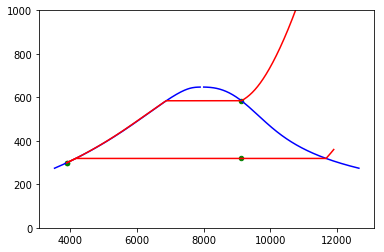

In [40]:
plot_water_curve(w)
plot_isobar(P_inicial)
plot_isobar(P_salida)

plot_estado(estado1)
plot_estado(estado2)
plot_estado(estado3)
plot_estado(estado4)

plt.show()